In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from xgboost import XGBClassifier
from scipy.stats import norm,chisquare
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
%matplotlib inline

In [ ]:
df = pd.read_csv('/credit_risk_dataset.csv')

In [ ]:
df.info() #Null values in person_emp_length and loan_int_rate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [ ]:
df['loan_status'].value_counts()  #Imbalanced dataset with more skewness towards 0, with 0 being non default and 1 being default

0    25473
1     7108
Name: loan_status, dtype: int64

In [ ]:
# import model and matrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve

In [ ]:
from sklearn.metrics import f1_score
df = df.dropna(axis=0, subset=['loan_int_rate'])

In [ ]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29465 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  29465 non-null  int64  
 1   person_income               29465 non-null  int64  
 2   person_home_ownership       29465 non-null  object 
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 29465 non-null  object 
 5   loan_grade                  29465 non-null  object 
 6   loan_amnt                   29465 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 29465 non-null  int64  
 9   loan_percent_income         29465 non-null  float64
 10  cb_person_default_on_file   29465 non-null  object 
 11  cb_person_cred_hist_length  29465 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.9+ MB


In [ ]:
df = df.dropna(axis = 0, subset = ['person_emp_length'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28638 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28638 non-null  int64  
 1   person_income               28638 non-null  int64  
 2   person_home_ownership       28638 non-null  object 
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 28638 non-null  object 
 5   loan_grade                  28638 non-null  object 
 6   loan_amnt                   28638 non-null  int64  
 7   loan_int_rate               28638 non-null  float64
 8   loan_status                 28638 non-null  int64  
 9   loan_percent_income         28638 non-null  float64
 10  cb_person_default_on_file   28638 non-null  object 
 11  cb_person_cred_hist_length  28638 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB


In [ ]:
df['loan_status'].value_counts()

0    22435
1     6203
Name: loan_status, dtype: int64

In [ ]:
df.loan_status.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'  #Value counts for the classifier labels as percentages

0    78.3%
1    21.7%
Name: loan_status, dtype: object

In [ ]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,28638.000000,2.863800e+04,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000
mean,27.727216,6.664937e+04,4.788672,9656.493121,11.039867,0.216600,0.169488,5.793736
std,6.310441,6.235645e+04,4.154627,6329.683361,3.229372,0.411935,0.106393,4.038483
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.948000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.595600e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


<Axes: ylabel='person_age'>

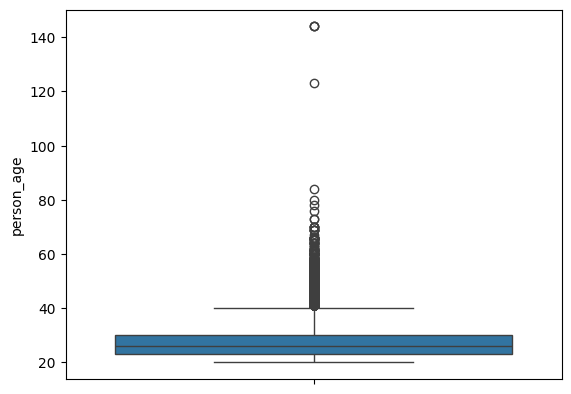

In [ ]:
sns.boxplot(df['person_age'])

In [ ]:
df[df['person_age']>70].count()  #Remove 10 people who were more than 70 years of age

person_age                    10
person_income                 10
person_home_ownership         10
person_emp_length             10
loan_intent                   10
loan_grade                    10
loan_amnt                     10
loan_int_rate                 10
loan_status                   10
loan_percent_income           10
cb_person_default_on_file     10
cb_person_cred_hist_length    10
dtype: int64

In [ ]:
df = df[df['person_age'] <= 70]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28628 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28628 non-null  int64  
 1   person_income               28628 non-null  int64  
 2   person_home_ownership       28628 non-null  object 
 3   person_emp_length           28628 non-null  float64
 4   loan_intent                 28628 non-null  object 
 5   loan_grade                  28628 non-null  object 
 6   loan_amnt                   28628 non-null  int64  
 7   loan_int_rate               28628 non-null  float64
 8   loan_status                 28628 non-null  int64  
 9   loan_percent_income         28628 non-null  float64
 10  cb_person_default_on_file   28628 non-null  object 
 11  cb_person_cred_hist_length  28628 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB


In [ ]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,28628.000000,2.862800e+04,28628.000000,28628.000000,28628.000000,28628.000000,28628.000000,28628.000000
mean,27.701306,6.643187e+04,4.786782,9657.148596,11.040087,0.216676,0.169514,5.789437
std,6.130424,5.155555e+04,4.148013,6329.854518,3.229637,0.411987,0.106392,4.028095
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.945600e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.590000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,70.000000,2.039784e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [ ]:
df = df[df['person_emp_length']<100]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28626 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28626 non-null  int64  
 1   person_income               28626 non-null  int64  
 2   person_home_ownership       28626 non-null  object 
 3   person_emp_length           28626 non-null  float64
 4   loan_intent                 28626 non-null  object 
 5   loan_grade                  28626 non-null  object 
 6   loan_amnt                   28626 non-null  int64  
 7   loan_int_rate               28626 non-null  float64
 8   loan_status                 28626 non-null  int64  
 9   loan_percent_income         28626 non-null  float64
 10  cb_person_default_on_file   28626 non-null  object 
 11  cb_person_cred_hist_length  28626 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB


In [ ]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,28626.000000,2.862600e+04,28626.000000,28626.000000,28626.000000,28626.000000,28626.000000,28626.000000
mean,27.701740,6.642775e+04,4.778523,9655.901977,11.040070,0.216656,0.169502,5.789597
std,6.130418,5.155199e+04,4.028743,6328.007742,3.229507,0.411974,0.106366,4.028188
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.945600e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.590000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,70.000000,2.039784e+06,38.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [ ]:
lb = 7.900000 - 1.5 * (13.480000 - 7.900000)
ub = 13.480000 + 1.5 * (13.480000 - 7.900000)

In [ ]:
ub

21.85

In [ ]:
df[df['loan_int_rate']>21.85].count()